<a href="https://colab.research.google.com/github/forbiddenvelocity/Image-Generator-AI/blob/main/GAN_Image_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import tensorflow_datasets as tfds

In [4]:
ds = tfds.load('fashion_mnist', split='train' )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete822SPM/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete822SPM/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# **Visualizing Dataset**

In [5]:
import numpy as np

In [6]:
dataIteration = ds.as_numpy_iterator()

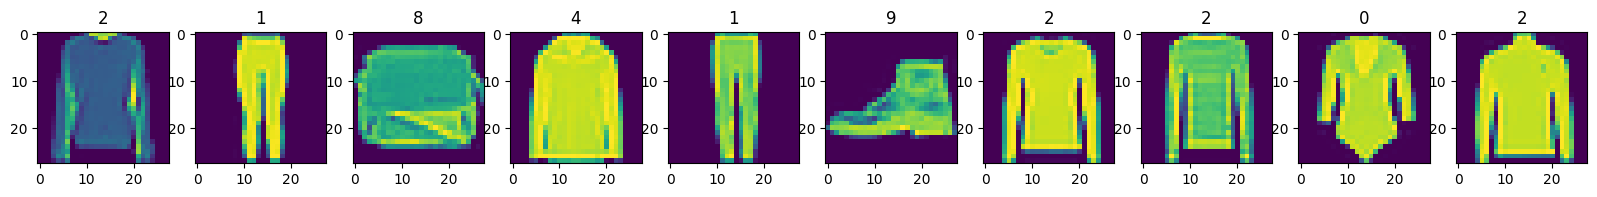

In [7]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for index in range(10):
  batch = dataIteration.next()
  ax[index].imshow(np.squeeze(batch['image']))
  ax[index].title.set_text(batch['label'])

In [8]:
def scale_images(data):
    img = data['image']
    return img/255

In [9]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [10]:
check = ds.as_numpy_iterator().next()

# **Neural Networks**

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Building Generator

In [12]:
def build_generator():
  model = Sequential()
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128,5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128,4, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1,4, padding='same', activation='sigmoid'))

  return model

In [13]:
test_model = build_generator()

In [14]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
generator = build_generator()

In [16]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 7s 7s/step


1/1 [==============================] - 0s 22ms/step


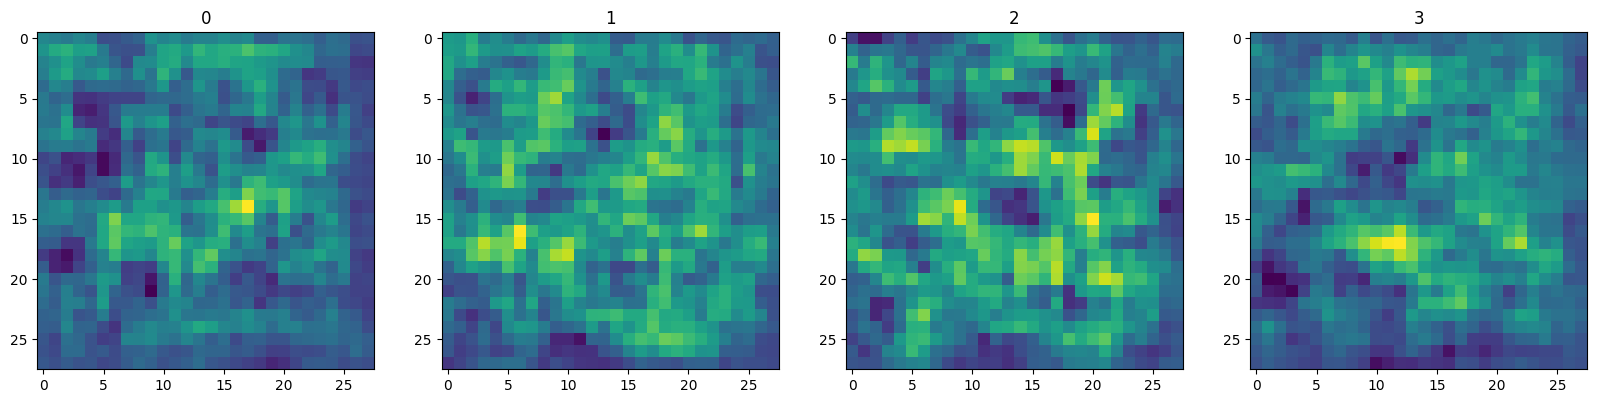

In [18]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(img):
  ax[index].imshow(np.squeeze(img))
  ax[index].title.set_text(index)

Building Discriminator

In [22]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model


In [23]:
discriminator = build_discriminator()

In [24]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      